# DCGAN MNIST

### Imports

In [9]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from einops import rearrange

from IPython.display import Image

### Hyperparameters etc.

In [12]:
latent_dim = 64
image_size = 64
batch_size = 32
learning_rate = 1e-3
epochs = 10
logging_interval = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Generator

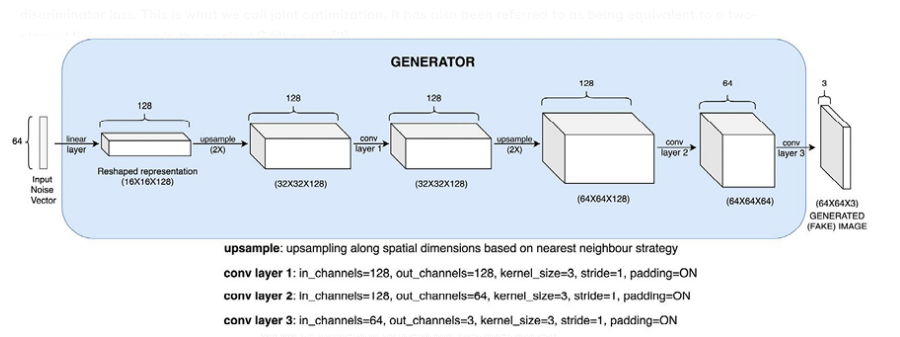

In [3]:
Image('images/dcgan-generator.png')

In [5]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.input_size = image_size // 4
        self.linear = nn.Linear(latent_dim, 128 * self.input_size ** 2)
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(128, 128, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(64, 1, 3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear(x)
        x = rearrange(x, 'b (c h w) -> b c h w', 
                c=128, h=self.input_size, w=self.input_size)
        x = self.batch_norm1(x)
        x = self.upsample1(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu1(x)
        x = self.upsample2(x)
        x = self.conv2(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        return x

### Discriminator

Note that the input images have 1 channel, not 3.

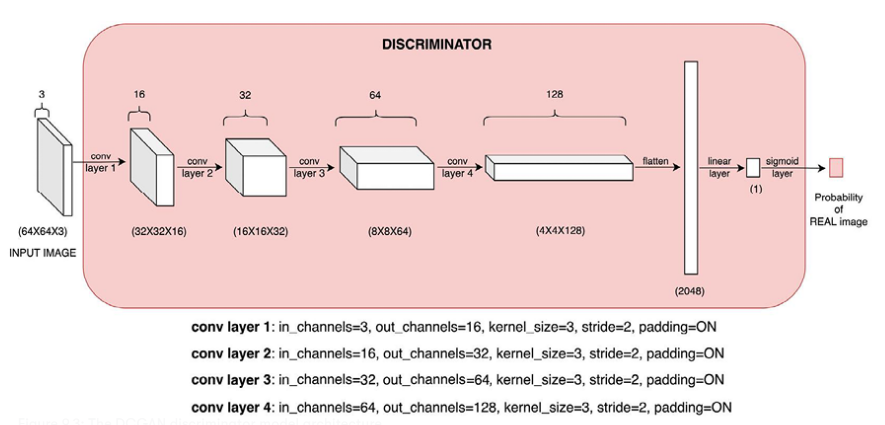

In [6]:
Image('images/dcgan-discriminator.png')

In [7]:
class DiscriminatorModule(nn.Module):

    def __init__(self, in_channels, out_channels, do_batch_norm=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout2d(0.25)
        self.batch_norm = nn.BatchNorm2d(out_channels) 

    def forward(self, x):
        x = self.conv(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        if do_batch_norm:
            x = self.batch_norm(x)
        return x    

In [8]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.discriminator_modules = nn.Sequential(
            DiscriminatorModule(1, 16, do_batch_norm=False),
            DiscriminatorModule(16, 32),
            DiscriminatorModule(32, 64),
            DiscriminatorModule(64, 128)
        )
        self.linear = nn.Linear(128 * 4 * 4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):     
        x = self.discriminator_modules(x)
        x = rearrange(x, 'b c h w -> b (c h w)')
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

### Dataset and dataloader

In [11]:
dataset = datasets.MNIST('/data', train=True, download=True, 
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Instantiate generator and discriminator; define loss function amd optimizors

In [13]:
gen = Generator()
disc = Discriminator()  
loss_fn = nn.BCELoss()

optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

### Function to train DCGAN

In [ ]:
def train_dcgan(epochs=10):
    for epoch in range(epochs):
        for idx, (images, _) in enumerate(dataloader):

            batch_size = images.shape[0]
            real_images = images
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            fake_labels = fake_labels.to(device)

            # Train generator
            optimizer_gen.zero_grad()
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = gen(noise)
            g_loss = loss_fn(disc(fake_images), real_labels)
            g_loss.backward()
            optimizer_gen.step()

            # Train discriminator
            optimizer_disc.zero_grad()
            real_loss = loss_fn(disc(real_images), real_labels)
            



            z = torch.randn(batch_size, latent_dim).to('cuda')
            fake_images = gen(z)
            fake_outputs = disc(fake_images)
            fake_loss = loss_fn(fake_outputs, fake_labels)
            fake_score = fake_outputs

            d_loss = real_loss + fake_loss
            d_loss.backward()
            disc_opt.step()

  

            if idx % logging_interval == 0:
                print(f'Epoch [{epoch}/{epochs}], Step [{idx}/{len(dataloader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

In [ ]:
def train_dcgan(epochs=10):
    for epoch in range(epochs):
        for idx, (images, _) in enumerate(dataloader):

            batch_size = images.shape[0]
            real_images = images
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            fake_labels = fake_labels.to(device)

            # Train generator
            optimizer_gen.zero_grad()
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = gen(noise)
            g_loss = loss_fn(disc(fake_images), real_labels)
            g_loss.backward()
            optimizer_gen.step()

            # Train discriminator
            optimizer_disc.zero_grad()
            real_outputs = disc(real_images)
            real_loss = loss_fn(real_outputs, real_labels)
            real_score = real_outputs

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = gen(z)
            fake_outputs = disc(fake_images)
            fake_loss = loss_fn(fake_outputs, fake_labels)
            fake_score = fake_outputs

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_disc.step()

            if idx % logging_interval == 0:
                print(f'Epoch [{epoch}/{epochs}], Step [{idx}/{len(dataloader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')